<a href="https://colab.research.google.com/github/raafitt/GoogleColab/blob/U-net%2B%2B/U_net%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сегментация рентгеновских снимков легких с помощью архитектуры U-net++

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gsmkkddvbki
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:05<00:00, 150MB/s]


Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import random
import sys

import skimage.io
import skimage.transform
from skimage.morphology import label
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

### Подготовка данных

In [ ]:
IMG_WIDTH       = 128
IMG_HEIGHT      = 128
IMG_CHANNELS    = 3

x_path='/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
y_path='/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks'



In [ ]:
#функция загрузки изображений для входа модели
def get_X_data(path, output_shape=(None, None)):
    img_paths = ['{0}/{1}'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:],
                                                output_shape=output_shape,
                                                mode='constant',
                                                preserve_range=True) for path in img_paths], dtype=np.uint8)  #оставляем 3 канала

    return X_data

In [ ]:
#функция загрузки изображений для выхода модели (маски)
def get_Y_data(path, output_shape=(None, None)):
    img_paths = [glob.glob('{0}/{1}'.format(path, id)) for id in os.listdir(path)]

    Y_data = []
    for i, img_masks in enumerate(img_paths):
        masks = skimage.io.imread_collection(img_masks).concatenate()  #размерность маски = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #добавление дополнительного измерения к маске
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool_)

    return Y_data

In [ ]:
# Получение обучающих данных
X_train = get_X_data(x_path, output_shape=(IMG_HEIGHT,IMG_WIDTH))
Y_train = get_Y_data(y_path, output_shape=(IMG_HEIGHT,IMG_WIDTH))

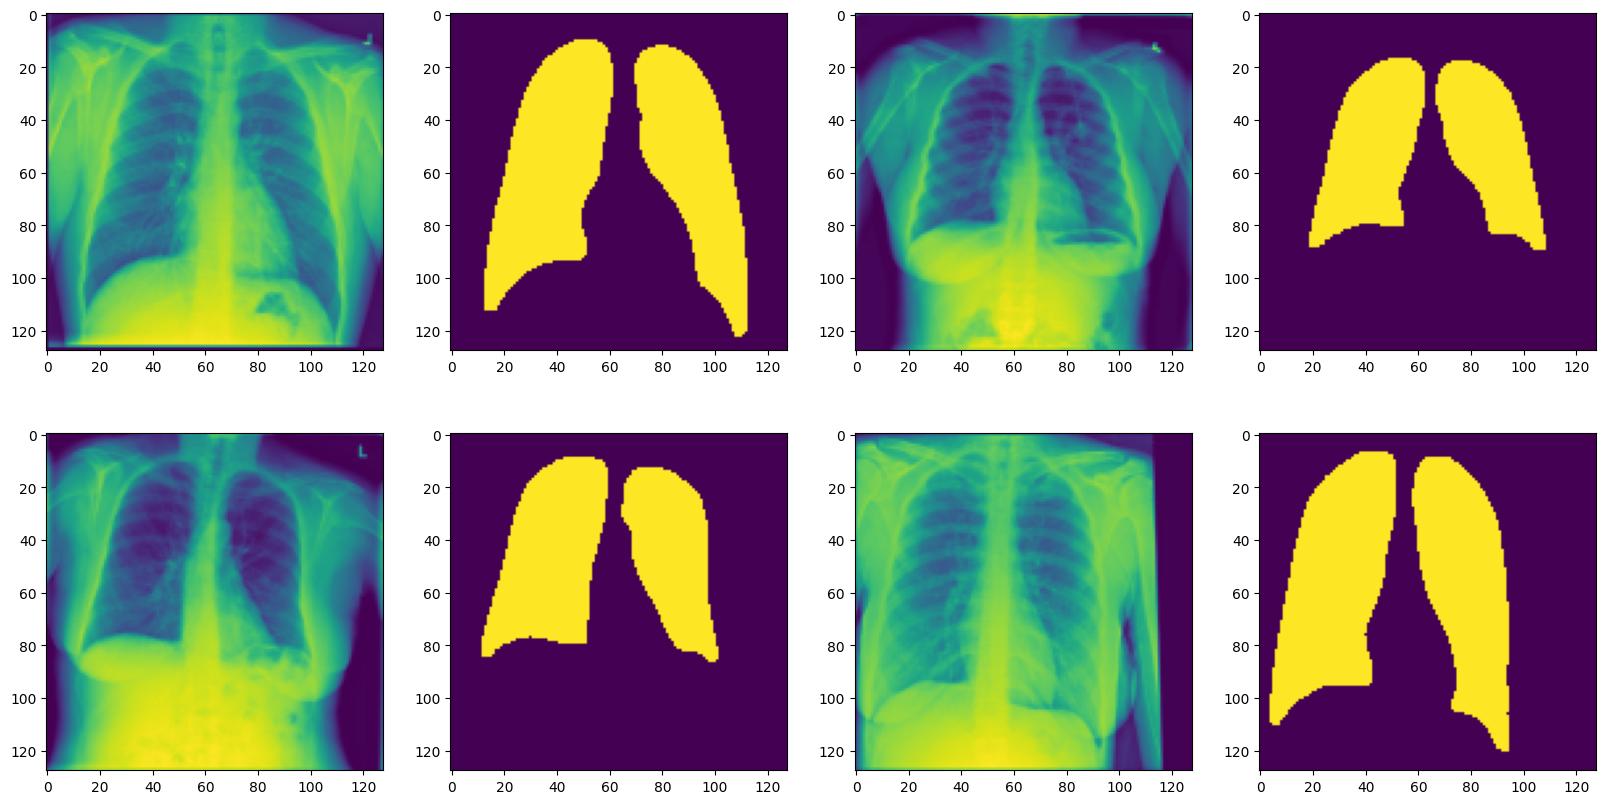

In [ ]:
#Выводим изображения и маски
f, axarr = plt.subplots(2,4)
f.set_size_inches(20,10)

axarr[0,0].imshow(X_train[4])
axarr[0,1].imshow(np.squeeze(Y_train[4]))

axarr[0,2].imshow(X_train[5])
axarr[0,3].imshow(np.squeeze(Y_train[5]))

axarr[1,0].imshow(X_train[6])
axarr[1,1].imshow(np.squeeze(Y_train[6]))

axarr[1,2].imshow(X_train[7])
axarr[1,3].imshow(np.squeeze(Y_train[7]))

plt.show()

In [ ]:
# Получение обучающих и тестовых данных
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=13)

### Построение сети

Функция потерь

In [ ]:
# шаг обучения
LR = 0.001
# коэфициент для функция потерь
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# модифицированная функция потерь
def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

NUM_EPOCHS=10

Архитектура UNet++

In [ ]:
tf.keras.backend.clear_session()
nb_filter = [32,64,128,256,512]
# Build U-Net++ model
inputs = Input((IMG_HEIGHT, IMG_WIDTH,1))
s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.5) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.5) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Dropout(0.5) (c3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Dropout(0.5) (conv3_1)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Dropout(0.5) (conv4_1)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Dropout(0.5) (conv5_1)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

model = Model([inputs], [nestnet_output_4])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=bce_dice_loss)

Обучение сети

In [ ]:
#адаптивный шаг обучения
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.00005)
history = model.fit(x_train,y_train,
                    steps_per_epoch=int(len(X_train) / 6),
                    callbacks=[reduce_lr],
                    epochs=NUM_EPOCHS,
                    verbose=1,)

Epoch 1/10
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 248s 109ms/step - loss: -0.5846 - learning_rate: 0.0010
Epoch 2/10


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1698/1698 ━━━━━━━━━━━━━━━━━━━━ 174s 84ms/step - loss: -0.9318 - learning_rate: 0.0010
Epoch 3/10
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 141s 83ms/step - loss: -0.9508 - learning_rate: 0.0010
Epoch 4/10
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 142s 83ms/step - loss: -0.9526 - learning_rate: 0.0010
Epoch 5/10
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 142s 83ms/step - loss: -0.9609 - learning_rate: 0.0010
Epoch 6/10
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 144s 84ms/step - loss: -0.9646 - learning_rate: 0.0010
Epoch 7/10
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 203s 85ms/step - loss: -0.9680 - learning_rate: 0.0010
Epoch 8/10
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 202s 85ms/step - loss: -0.9660 - learning_rate: 0.0010
Epoch 9/10
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 201s 85ms/step - loss: -0.9634 - learning_rate: 0.0010
Epoch 10/10
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 200s 83ms/step - loss: -0.9679 - learning_rate: 0.0010


Предсказания на тестовых изображениях

In [ ]:
#предсказания на тестовых изображениях
Y_predict = model.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step


### Вывод изображений

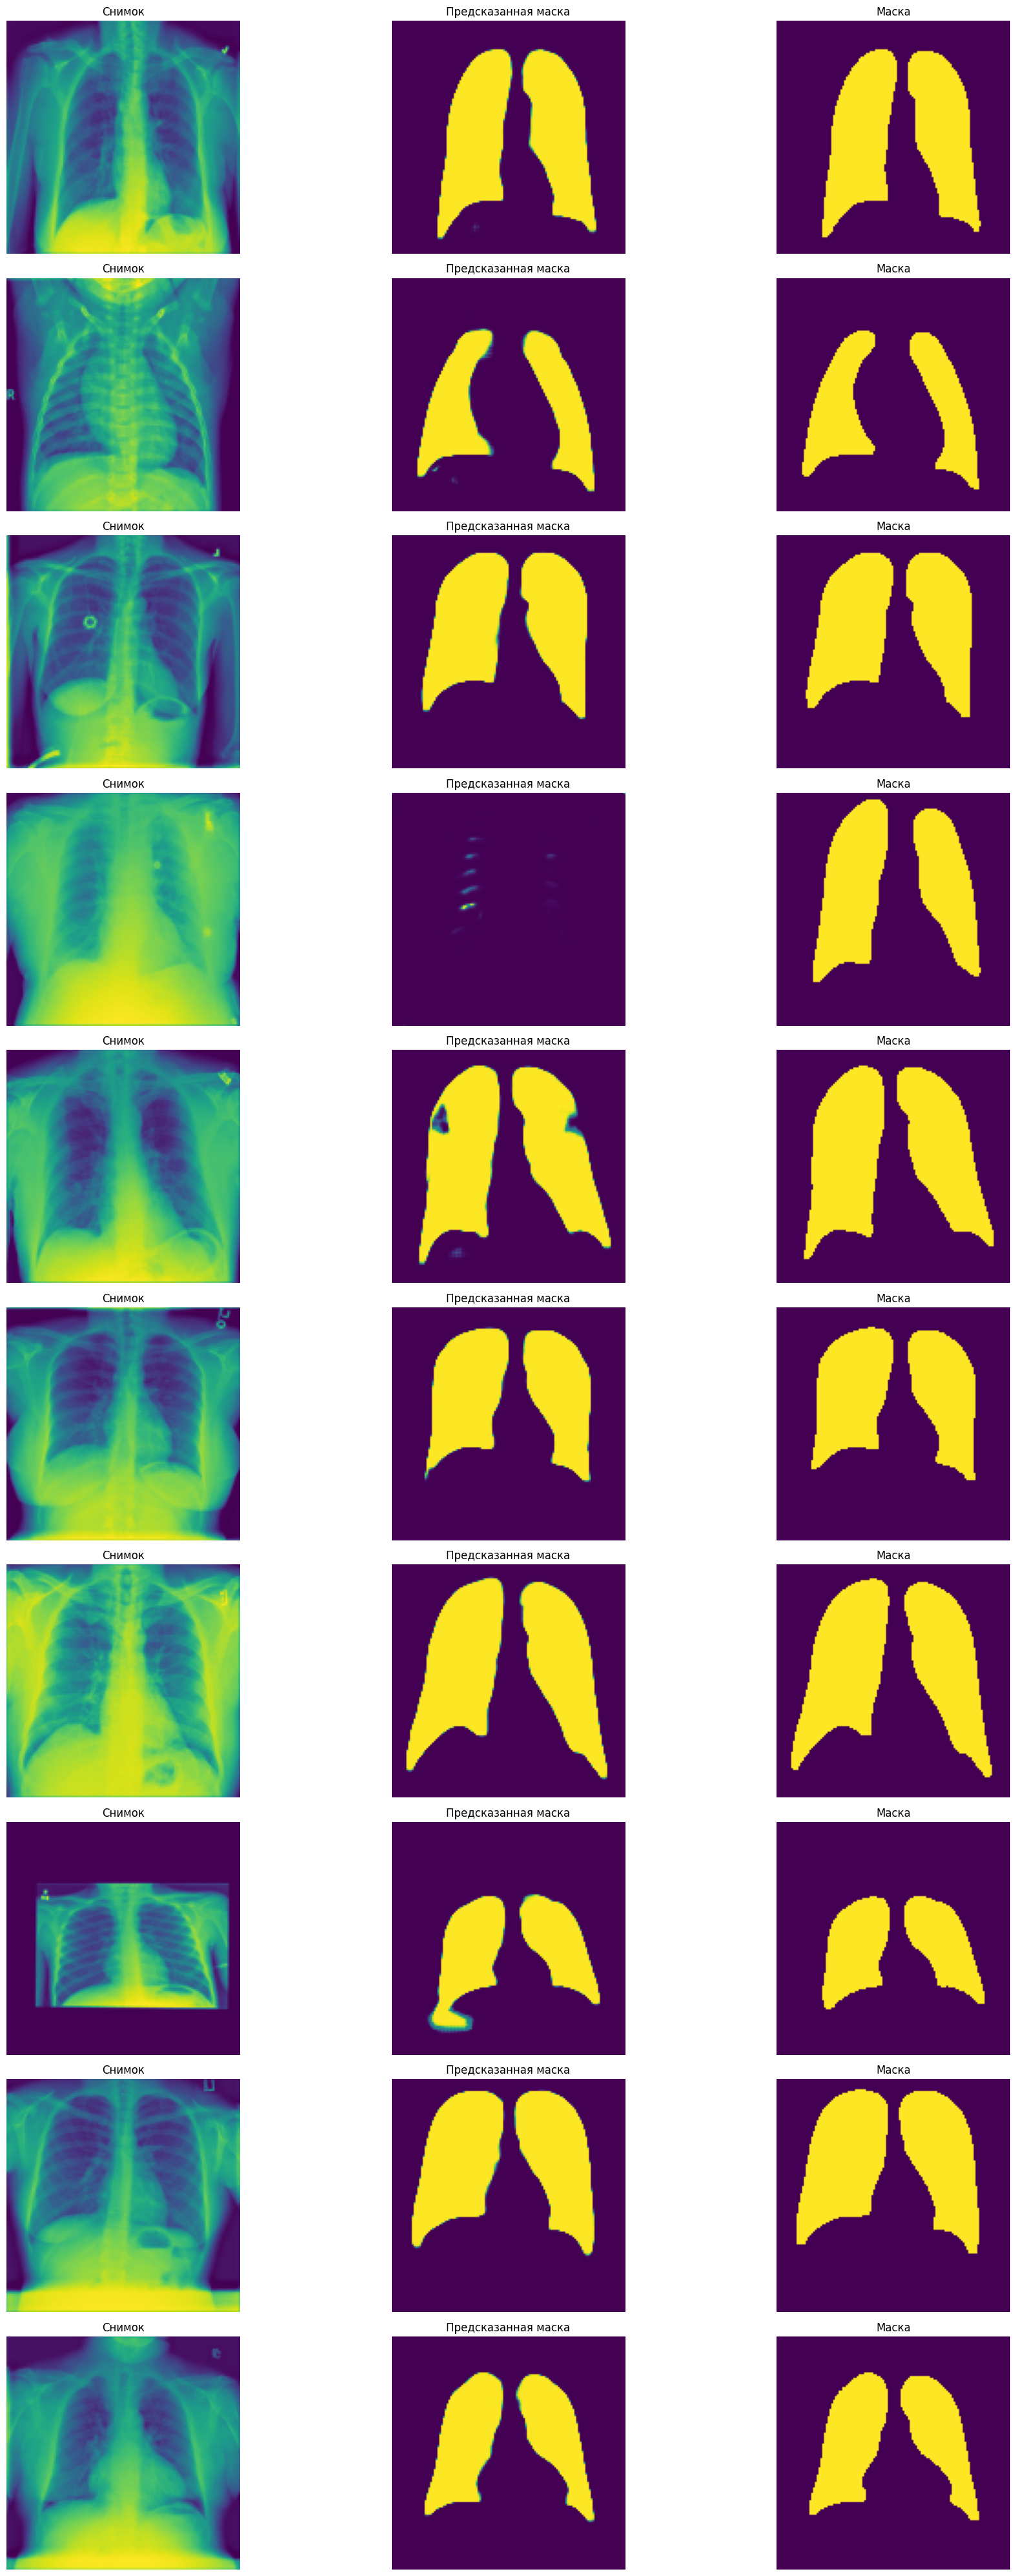

In [ ]:
# Задаем размеры фигур при создании
f, axs = plt.subplots(10, 3, figsize=(20, 40))


for ix in range(0, 10):
    axs[ix, 0].imshow(x_test[ix])  # Исходное изображение
    axs[ix, 0].set_title('Снимок', fontsize=12)
    axs[ix, 0].axis('off')  # Убираем оси

    axs[ix, 1].imshow(np.squeeze(Y_predict[ix]))  # Предсказанная маска
    axs[ix, 1].set_title('Предсказанная маска', fontsize=12)
    axs[ix, 1].axis('off')

    axs[ix, 2].imshow(np.squeeze(y_test[ix]))  # Истинная маска
    axs[ix, 2].set_title('Маска', fontsize=12)
    axs[ix, 2].axis('off')

# Показываем графики
plt.tight_layout()  # Для автоматической подгонки элементов
plt.show()
